# Кластеризация

## Цели работы:
1. Реализовать алгоритм кластеризации и две меры качества.
2. Реализовать алгоритм сокращения размерности.
3. Анализ результатов.

## Задание

Реализуйте любой алгоритм кластеризации на выбор: 

1. K-Means;
2. DBSCAN;
3. иерархический алгоритм.

Также реализуйте две метрики качества кластеризации: одну внешнюю и одну внутреннюю. Внутренняя мера качества должна учитывать как межкластерные так и внутрикластерные расстояния.

Варианты внешних мер ([формулы](http://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D1%86%D0%B5%D0%BD%D0%BA%D0%B0_%D0%BA%D0%B0%D1%87%D0%B5%D1%81%D1%82%D0%B2%D0%B0_%D0%B2_%D0%B7%D0%B0%D0%B4%D0%B0%D1%87%D0%B5_%D0%BA%D0%BB%D0%B0%D1%81%D1%82%D0%B5%D1%80%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8) ):

1. Rand index
2. Jaccard index
3. F-мера
	
Варианты внутренних мер:

1. Силуэтный индекс
2. метрика Calinski-Harabasz
3. метрика Dunn

Нарисуйте два графика: набор данных с реальными метками и с метками полученными в результате кластеризации. Постарайтесь выбрать такие гиперпараметры  алгоритма кластеризации, чтобы результат кластеризации был как можно более похож на реальные метки. Для отрисовки многомерных данных используйте алгоритм сокращения размерности (например PCA или tSNE), но кластеризацию по прежнему проводите в многомерном пространстве.

Постройте график зависимости выбранных метрик качества кластеризации от числа кластеров при выборе K-Means или иерархического алгоритма. В случае DBSCAN постройте график зависимости выбранных метрик качества кластеризации от радиуса шара.

## Наборы данных

Возьмите любой небольшой набор данных из OpenML или Kaggle

# Imports

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics.cluster import pair_confusion_matrix
from sklearn.cluster import KMeans

# Data preparation

In [16]:
sleep = pd.read_csv('sleep.csv')
sleep


,id,gpa,sleep,passed_unit_tests,passed_asserts,tackled_user_stories
0,1,23,normal,5,6,5
1,2,24,normal,1,3,2
2,3,23,normal,7,6,5
3,4,28,normal,5,8,4
4,5,25,normal,4,5,3
5,7,23,normal,1,4,2
6,8,28,normal,4,5,3
7,9,23,normal,4,5,3
8,10,22,normal,4,5,3
9,11,26,normal,1,6,2


In [82]:
X_ = pd.DataFrame(sleep, columns=['gpa', 'passed_unit_tests', 'passed_asserts', 'tackled_user_stories'])
X_['tests'] = X_['passed_unit_tests'] / X_['gpa']
X_['asserts'] = X_['passed_asserts'] / X_['gpa']
X_['user_stories'] = X_['tackled_user_stories'] / X_['gpa']
features=['tests','asserts','user_stories']
X = pd.DataFrame(X_, columns=features)
X = pd.DataFrame(normalize(X), columns=features)
y_ = sleep.sleep

X.head()

,tests,asserts,user_stories
0,0.539164,0.646997,0.539164
1,0.267261,0.801784,0.534522
2,0.667424,0.572078,0.476731
3,0.487950,0.780720,0.390360
4,0.565685,0.707107,0.424264


In [33]:
y = [0 if i == 'normal' else 1 for i in y_]
print(y)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


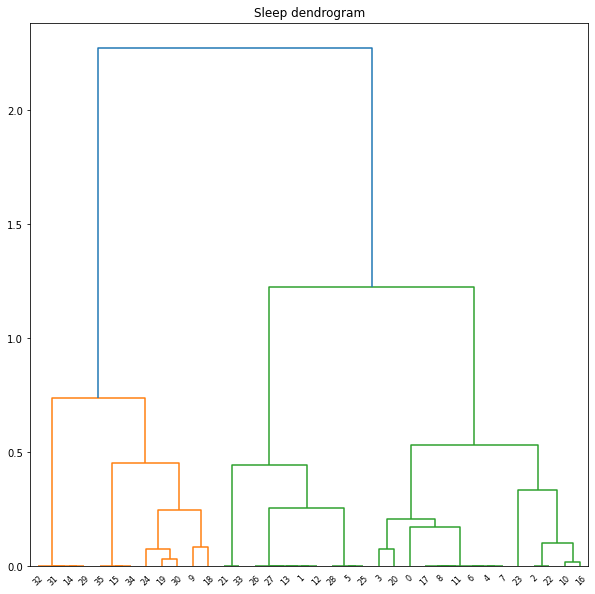

In [7]:
plt.figure(figsize=(10, 10))  
plt.title("Sleep dendrogram")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))

# Clustering

In [46]:
cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')  
labels_h = cluster.fit_predict(X)
labels_h

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1])

In [47]:
pair_confusion_matrix(y, labels_h)

array([[304, 326],
       [272, 358]])

In [48]:
homogeneity_score(y, labels_h)

0.04189195214748088

In [57]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
labels_km = kmeans.predict(X)
labels_km

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [58]:
pair_confusion_matrix(y, labels_km)

array([[342, 288],
       [288, 342]])

In [59]:
metrics.homogeneity_score(y, labels_km) #better

0.07329452045866312

# Inner metrics

In [60]:
# silhouette
print('Silhouette metrics')
print('KMeans: ', metrics.silhouette_score(X, labels_km, metric='euclidean'))
print('Ward hierarchy: ', metrics.silhouette_score(X, labels_h, metric='euclidean'))

Silhouette metrics
KMeans:  0.5334081980342152
Ward hierarchy:  0.5436987880363645


In [61]:
# calinski-harabasz
print('Calinski-Harabasz metrics')
print('KMeans: ', metrics.calinski_harabasz_score(X, labels_km))
print('Ward hierarchy: ', metrics.calinski_harabasz_score(X, labels_h))

Calinski-Harabasz metrics
KMeans:  60.17620091483149
Ward hierarchy:  57.22753343601533


# Outer metrics

In [67]:
# jaccard
print('Jaccard metrics')
print('KMeans (avg=macro): ', metrics.jaccard_score(y, labels_km, average='macro'))
print('Ward hierarchy (avg=macro): ', metrics.jaccard_score(y, labels_h, average='macro'))

Jaccard metrics
KMeans (avg=macro):  0.4920634920634921
Ward hierarchy (avg=macro):  0.4508620689655172


In [69]:
# rand
print('Rand metrics')
print('KMeans: ', metrics.cluster.rand_score(y, labels_km))
print('Ward hierarchy: ', metrics.cluster.rand_score(y, labels_h))

Rand metrics
KMeans:  0.5428571428571428
Ward hierarchy:  0.5253968253968254


# Plots

In [93]:
n_components=2
pca = PCA(n_components=n_components)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1', 'PC2'])
principalDf.head()

,PC1,PC2
0,0.309869,0.015153
1,0.025532,0.143851
2,0.417091,-0.102248
3,0.143682,-0.088890
4,0.252743,-0.097520


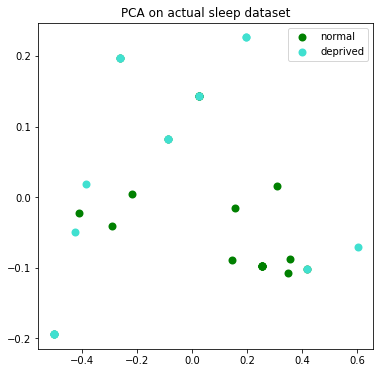

In [115]:
colors = ["green", "turquoise"]

for X in [principalComponents]:
    plt.figure(figsize=(6,6))
    for color, i, target_name in zip(colors, [0, 1], y_.unique()):
        plt.scatter(
            X[y_ == target_name, 0],
            X[y_ == target_name, 1],
            color=color,
            lw=2,
            label=target_name,
        )

    plt.title("PCA on actual sleep dataset")
    plt.legend(loc="best", shadow=False, scatterpoints=1)

plt.show()

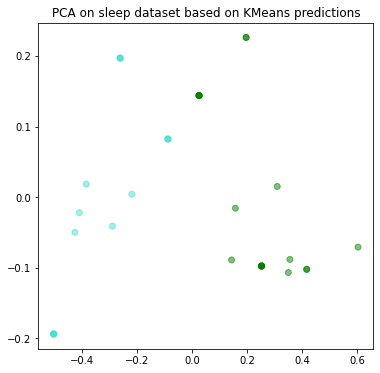

In [119]:
label_color_map = {0 : "green", 1 : "turquoise"}
label_color = [label_color_map[l] for l in labels_km]
X  = principalComponents

plt.figure(figsize = (6,6))
plt.scatter(X[:,0],X[:,1], c=label_color, alpha=0.5)
plt.title("PCA on sleep dataset based on KMeans predictions")
plt.show()

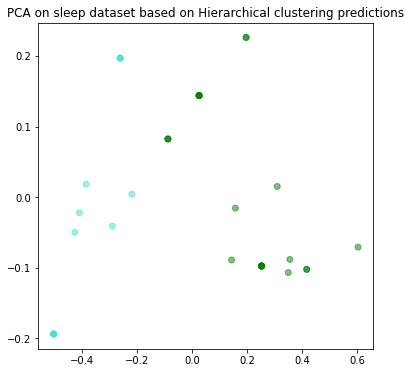

In [120]:
label_color_map = {0 : "green", 1 : "turquoise"}
label_color = [label_color_map[l] for l in labels_h]
X  = principalComponents

plt.figure(figsize = (6,6))
plt.scatter(X[:,0],X[:,1], c=label_color, alpha=0.5)
plt.title("PCA on sleep dataset based on Hierarchical clustering predictions")
plt.show()